In [5]:
using PlotlyJS, DataStructures, NBInclude

@nbinclude("Functions.ipynb")

run_examples = true

true

### Gaussian distribution example

We use $C$ and $g(c, \mu, \sigma)$ from [Functions.ipynb](Functions.ipynb).

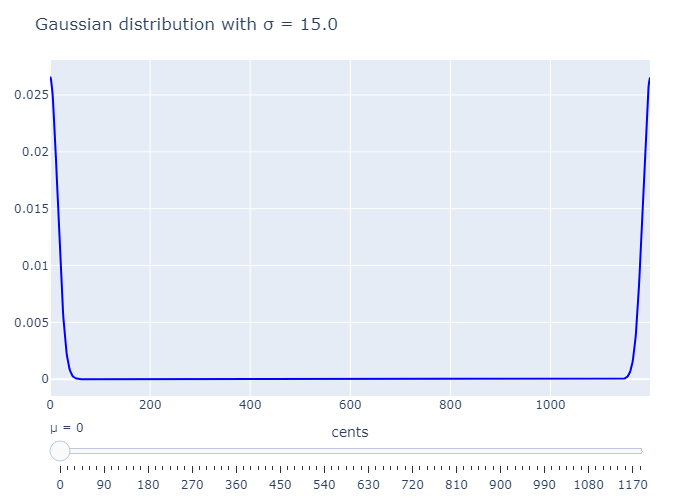

In [6]:
if run_examples
    σ = 15.

    μs = range(start = 0, stop = 1200, step=15)[1:end-1]
    num_μs = length(μs)

    traces = GenericTrace[]
    for μ in μs
        push!(traces, scatter(x=C, y=g.(C, Float64(μ), σ), visible=false, showlegend=false, line=attr(color="blue")))
    end
    μ = 0
    traces[1].visible = true

    layout = Layout(
        sliders=[attr(
            steps=[
                attr(
                    label=round(μ, digits=1),
                    method="update",
                    args=[attr(visible=[fill(false, i-1); true; fill(false, num_μs-i)])]
                )
                for (i, μ) in enumerate(μs)
            ],
            active = μ,
            currentvalue_prefix="μ = ",
        )],
        title = "Gaussian distribution with σ = $σ",
        xaxis_title = "cents",
    )

    p = plot(traces, layout)
    display(p)
end

# Harmonic Coupling (HC)

Inspired by [Harmonic Entropy](https://en.xen.wiki/w/Harmonic_entropy).

Farey ratios $F_k$:
$$F_1 = \{\cfrac{0}{1}, \cfrac{1}{1}\}$$
$$F_2 = \{\cfrac{0}{1}, \cfrac{1}{2}, \cfrac{1}{1}\}$$
$$F_3 = \{\cfrac{0}{1}, \cfrac{1}{3}, \cfrac{1}{2}, \cfrac{2}{3}, \cfrac{1}{1}\}$$
$$...$$

Harmonic Coupling (HC):
$$ HC(c, k, \sigma, \alpha) = S_{tretch}(HC_{norm}(c, k, \sigma, \alpha));
\quad c, \sigma \in C; \quad k \in \mathbb{N}; \quad \alpha \in \mathbb{R}_{\ge 0}$$
$$ S_{tretch}(arr)[i] = count(arr[i] < arr[j], 1 \le j \le n)/len(arr), 1 \le i \le n $$
$$ HC_{norm}(c, k, \sigma, \alpha) = normalize(HC_{raw}(c, k, \sigma, \alpha)) $$
$$ normalize(arr) = \cfrac{arr - min(arr)}{max(arr) - min(arr)} $$
$$ HC_{raw}(c, k, \sigma, \alpha) = \sum_{r = \frac{p}{q} \in F_k, r \ne 1}{\cfrac{g(c, r\cdot 1200, \sigma)}{q^\alpha}}$$

In [4]:
function farey(n::Int)
    rst = SortedSet{Rational}(Rational[0, 1])
    for den in 1:n, num in 1:den-1
        push!(rst, Rational(num, den))
    end
    return rst
end

function HC_frac(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        r::Rational, σ::Float64, α::Float64)
    return g.(C, Float64(r)*1200, σ)/denominator(r)^α
end

function HC_raw(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        k::Int, σ::Float64, α::Float64)
    fracs = farey(k)
    fracs = collect(fracs)[1:end-1]
    return sum(HC_frac(C, frac, σ, α) for frac in fracs)
end

normalize(arr::Vector{Float64}) = (arr .- minimum(arr)) ./ (maximum(arr) - minimum(arr))

function HC_norm(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        k::Int, σ::Float64, α::Float64)
    return normalize(HC_raw(C, k, σ, α))
end

function HC(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        k::Int, σ::Float64, α::Float64)
    HC_arr_norm = HC_norm(C, k, σ, α)
    len = length(C)
    HC_arr = zeros(len)
    for i in range(1, len)
        HC_arr[i] = count(x -> x < HC_arr_norm[i], HC_arr_norm)/len
    end
    return HC_arr
end

HC (generic function with 1 method)

### Harmonic Coupling example

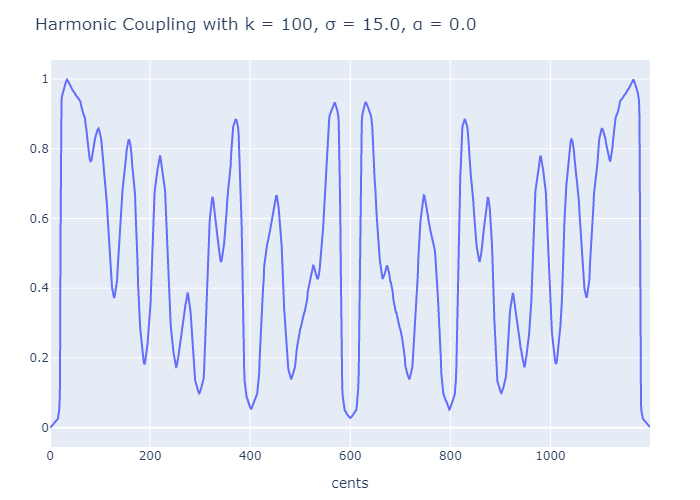

In [5]:
if run_examples
    k = 100
    σ = 15.
    α = 0.

    layout = Layout(
        title="Harmonic Coupling with k = $k, σ = $σ, α = $α",
        xaxis_title = "cents",
    )

    HC_arr = HC(C, k, σ, α)
    p = plot(C, HC_arr, layout)
    display(p)
end

# Input Pitch (IP)

Input pitch (IP), generated by notes $N = \{n_1, n_2, ..., n_m\}, n_i = (c_i, v_i), c_i \in C, v_i \in (0, 1]$, $c_i$ and $v_i$ are frequency and volume of $n_i$ note respectively:
$$ IP(c, N, \sigma) = \max_{n_i = (c_i, v_i) \in N}{g_{note}(c, c_i, \sigma, v_i)} $$
where $g_{note}(..., v_i)$ is a normalized $g$ multiplied by the volume $v_i$:
$$ g_{note}(..., v_i) = v_i\cdot normalize(g(...)) $$

# Pitch Memory (PM)

Pitch memory (PM) is calculated in two steps:
1. Attenuation due to inharmony using HC.  
Term $\Delta t$ makes PM independent of time step of simulation. $\lambda$ indicates the attenuation rate in PM.  
$$ PM(c, ..., \Delta t, \lambda) := PM(c, ...)(1 - \Delta t \cdot \lambda (\int_{0}^{1200}{PM(c, ...)HC(x-c, ...)dx})) $$  
2. Excitement due to the IP:
$$ PM(c, ...) := max(PM(c), IP(c, ...)) $$

In [6]:
function g_note(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        c_i::Float64, σ::Float64, v_i::Float64)
    return v_i .* normalize(g.(C, c_i, σ))
end

function IP(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        N::Vector{Vector{Float64}}, σ::Float64)
    IP = mapreduce(n_i -> g_note(C, n_i[1], σ, n_i[2]), (x, y) -> max.(x, y), N; init=zero(C))
    if IP != zero(C)
        IP = normalize(IP)
    end
    return IP
end

function PM_int(c::Float64, PM_arr::Vector{Float64}, HC_arr::Vector{Float64})
    index = Int(round(c/1200*length(PM_arr)))
    return sum(PM_arr .* circshift(HC_arr, index))
end

function PM(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        PM_arr::Vector{Float64}, IP_arr::Vector{Float64}, HC_arr::Vector{Float64}, 
        Δt::Float64, λ::Float64)
    PM_arr = PM_arr .* (1 .- Δt*λ*([PM_int(C[i], PM_arr, HC_arr) for i in 1:length(C)]))
    PM_arr = max.(PM_arr, IP_arr)
    return PM_arr
end

PM (generic function with 1 method)

### Input Pitch and Pitch Memory example

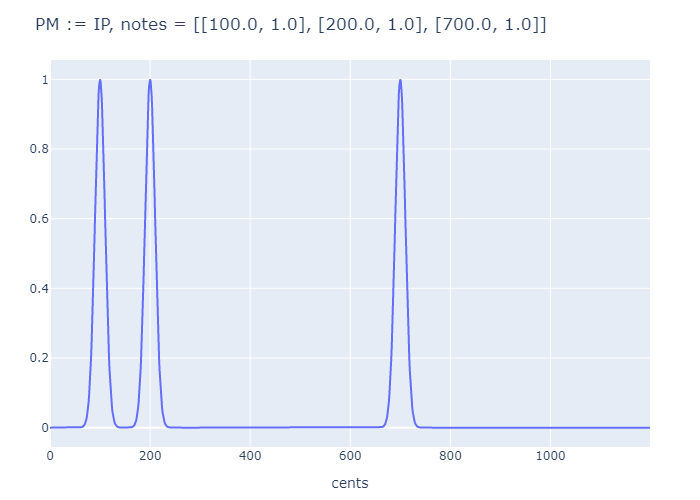

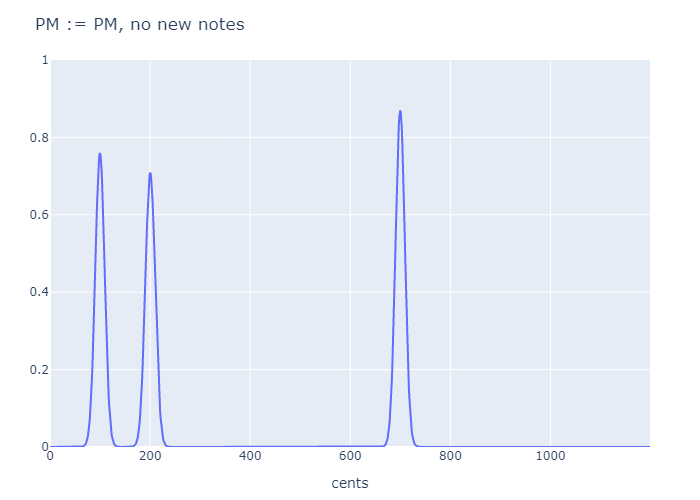

In [7]:
if run_examples
    σ = 10.
    notes = [[100., 1.], [200., 1.], [700., 1.]]
    IP1_arr = IP(C, notes, σ)
    IP2_arr = zeros(length(C))

    PM_arr = IP1_arr
    p1 = plot(C, PM_arr, Layout(
        title="PM := IP, notes = $notes",
        xaxis_title="cents"
    ))
    display(p1)

    k = 100
    α = 0.7
    Δt = 1.0
    λ = 0.01
    HC_arr = HC(C, k, σ, α)
    PM_arr = PM(C, PM_arr, IP2_arr, HC_arr, Δt, λ)
    p2 = plot(C, PM_arr, Layout(
        title="PM := PM, no new notes",
        xaxis_title="cents",
        yaxis_range = [0, 1]
    ))
    display(p2)
end

# Final Pitch Memory model

Now let's use time $t$ with step $\Delta t$.  
Melody consists of notes that have start time, pitch, volume and duration.  

In [8]:
struct Note
    start_time::Float64 # [0; +∞), seconds
    pitch::Float64      # [0; 1200), cents
    duration::Float64   # (0; +∞), seconds
    volume::Float64     # (0; 1]
end


struct Melody
    notes::Vector{Note}
end


function generate_IP(
        melody::Melody,
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        σ::Float64,
        ts::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
    
    function findNotesThatAreCurrentlyPlayed(curr_t::Float64)
        curr_notes = []
        for n in melody.notes
            if n.start_time <= curr_t <= n.start_time + n.duration
                push!(curr_notes, n)
            end
        end
        return curr_notes
    end

    melody_IP = Vector{Vector{Float64}}()

    for t_i in ts
        N = findNotesThatAreCurrentlyPlayed(t_i)
        pitches_and_volumes = Vector{Vector{Float64}}()
        for n in N
            push!(pitches_and_volumes, [n.pitch, n.volume])
        end

        push!(melody_IP, IP(C, pitches_and_volumes, σ))
    end

    return melody_IP
end


function run_PM_model(
        melody1_IP::Vector{Vector{Float64}}, 
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, 
        ts::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, 
        λ::Float64, σ::Float64, k::Int, α::Float64)
    HC_arr = HC(C, k, σ, α)
    melody_PM = Vector{Vector{Float64}}()

    Δt = ts[2]-ts[1]
    prev_PM = melody1_IP[1]
    for i in range(1, length(ts))
        prev_PM = PM(C, prev_PM, melody1_IP[i], HC_arr, Δt, λ)
        push!(melody_PM, prev_PM)
    end

    return melody_PM
end

run_PM_model (generic function with 1 method)

### Pitch Memory model example

In [ ]:
if run_examples
    melody1 = Melody([
        Note(     0,  500, 0.5, 1),
        Note(   0.6,  540, 0.5, 1),
        Note(   1.2, 1140, 0.5, 1),
        #Note(   1.8,  565, 0.5, 1)
    ])

    σ = 15.
    duration = 5.0
    Δt = 0.02
    ts = range(0, duration, step=Δt)
    melody1_IP = generate_IP(melody1, C, σ, ts)

    p_IP = plot(heatmap(x=ts, y=C, z=melody1_IP), Layout(
        title="Input Pitch, duration = $duration, Δt = $Δt, σ = $σ",
        xaxis_title="time (s)",
        yaxis_title="pitch (¢)",
    ))
    display(p_IP)

    λ = 0.1
    k = 100
    α = 0.5
    melody1_PM = run_PM_model(melody1_IP, C, ts, λ, σ, k, α)

    p_IP = plot(heatmap(x=ts, y=C, z=melody1_PM), Layout(
        title="Pitch Memory, duration = $duration, Δt = $Δt, σ = $σ, λ = $λ, k = $k, α = $α",
        xaxis_title="time (s)",
        yaxis_title="pitch (¢)",
    ))
    display(p_IP)
end